## Running hyperparameter optimization - Part 1

This notebook goes through the hyperparameter tuning of MOVE.

The optimal settings are identified based on multiple steps cosidering both
reconstruction on the test and training sets as well as the stability/similiarity
of the latent space in case of repeated training. Herein, we focus on the test
and training reconstruction accuracies.

Note that because we are training multiple models and recording their metrics,
it's best to run this task from the command line. You can do so with the
following command*:

\* Note: the command may take a while, and will not display any progress
message if ran directly from the notebook. However, a log file will report the 
progress.

In [1]:
! move-dl experiment=random_small__tune

[INFO  - tune_model]: Beginning task: tune model 1
[INFO  - tune_model]: Job name: task.batch_size=10,task.model.num_hidden=[500],task.training_loop.num_epochs=40
[INFO  - tune_model]: Reconstructing
[INFO  - tune_model]: Computing reconstruction metrics
[INFO  - tune_model]: Writing results
[INFO  - tune_model]: Beginning task: tune model 2
[INFO  - tune_model]: Job name: task.batch_size=10,task.model.num_hidden=[500],task.training_loop.num_epochs=60
[INFO  - tune_model]: Reconstructing
[INFO  - tune_model]: Computing reconstruction metrics
[INFO  - tune_model]: Writing results
[INFO  - tune_model]: Beginning task: tune model 3
[INFO  - tune_model]: Job name: task.batch_size=10,task.model.num_hidden=[500],task.training_loop.num_epochs=100
[INFO  - tune_model]: Reconstructing
[INFO  - tune_model]: Computing reconstruction metrics
[INFO  - tune_model]: Writing results
[INFO  - tune_model]: Beginning task: tune model 4
[INFO  - tune_model]: Job name: task.batch_size=10,task.model.num_hid

The output of the previous command is a TSV table, recording the metrics of each
 run.

In [83]:
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv("../results_cont/tune_model/reconstruction_stats.tsv", sep="\t")

In this tutorial, we looked at different batch size and number of training
epochs.

In [86]:
plot_data = results[lambda df: (df["task.batch_size"] == 10)] # & (df["task.training_loop.num_epochs"] == 150) ]

prot_g1 = plot_data[lambda df: (df["task.model.num_hidden"] == "[200]") & (df["dataset"] == "random.continuous.proteomics") & (df["split"] == "train") ]
prot_g1_stats = prot_g1.to_dict(orient="records")

prot_g2 = plot_data[lambda df: (df["task.model.num_hidden"] == "[200]") & (df["dataset"] == "random.continuous.proteomics") & (df["split"] == "test") ]
prot_g2_stats = prot_g2.to_dict(orient="records")

prot_g3 = plot_data[lambda df: (df["task.model.num_hidden"] =="[200]") & (df["dataset"] == "random.continuous.metagenomics") & (df["split"] == "train")]
prot_g3_stats = prot_g3.to_dict(orient="records")

prot_g4 = plot_data[lambda df: (df["task.model.num_hidden"] == "[200]") & (df["dataset"] == "random.continuous.metagenomics") & (df["split"] == "test")]
prot_g4_stats = prot_g4.to_dict(orient="records")

print(prot_g1)
# matplotlib complains if fliers are unset
for bxp_stats in chain(prot_g1_stats, prot_g2_stats, prot_g3_stats, prot_g4_stats):
    bxp_stats["fliers"] = []

    job_num  task.batch_size task.model.num_hidden  task.model.num_latent  \
0         1               10                 [200]                     50   
4         2               10                 [200]                     50   
8         3               10                 [200]                     50   
12        4               10                 [200]                     50   
16        5               10                 [200]                     50   

    task.training_loop.num_epochs             metric  \
0                              25  cosine_similarity   
4                              50  cosine_similarity   
8                             100  cosine_similarity   
12                            150  cosine_similarity   
16                            200  cosine_similarity   

                         dataset  split      mean       iqr      cilo  \
0   random.continuous.proteomics  train  0.161545  0.106002  0.156860   
4   random.continuous.proteomics  train  0.302291  0.0

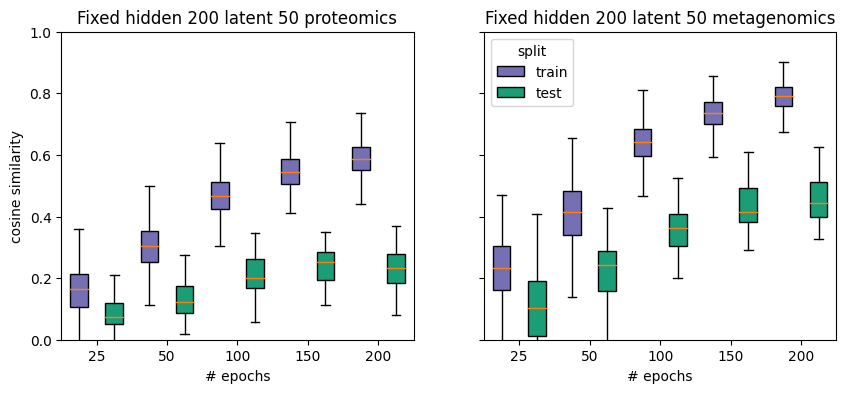

In [88]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

coll1 = axs[0].bxp(prot_g1_stats, positions=[*range(0, 10, 2)], boxprops=dict(facecolor="#7570b3"), patch_artist=True)
coll2 = axs[0].bxp(prot_g2_stats, positions=[*range(1, 10, 2)], boxprops=dict(facecolor="#1b9e77"), patch_artist=True)

axs[1].bxp(prot_g3_stats, positions=[*range(0, 10, 2)], boxprops=dict(facecolor="#7570b3"), patch_artist=True)
axs[1].bxp(prot_g4_stats, positions=[*range(1, 10, 2)], boxprops=dict(facecolor="#1b9e77"), patch_artist=True)

axs[0].set(
    xticks=np.arange(0.5, 10, 2), xticklabels=[25, 50, 100, 150, 200], ylim=(0, 1),
    xlabel="# epochs", ylabel="cosine similarity", title="Fixed hidden 200 latent 50 proteomics",
)
axs[1].set(
    xticks=np.arange(0.5, 10, 2), xticklabels=[25, 50, 100, 150, 200],
    xlabel="# epochs", title="Fixed hidden 200 latent 50 metagenomics"
)

axs[1].legend([coll1["boxes"][0], coll2["boxes"][0]], ["train", "test"], title="split")

plt.show()

From the above plot, we can easily see the relation between increasing the
number of epochs and improving the accuracy of reconstructing the proteomics
dataset. We can also see that in this case a smaller batch size is a better
choice.

The same type of plot can be generated for the other set of hyperparameters and
datasets.